<a href="https://colab.research.google.com/github/pizzapuppies/Youssif_FYP_Code/blob/main/hyper_tuned_concentration_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q -U keras-tuner
from google.colab import drive
import pandas as pd 
import os
import tensorflow as tf
import numpy as np  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import csv
import random
from tensorflow import keras
import sys
from matplotlib import pyplot as plt
import keras_tuner as kt
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Data preprocessing

In [ ]:
#@title spliting the data

data = {}

"""
data = {    
    "n": [. . . ],
    "p0.5": [. . .],
    .
    .
    .
    "p32":[. . .]
}
"""
with open("/content/gdrive/My Drive/data.csv","r") as rfile:
  reader  = csv.reader(rfile)
  real,imag = [],[]
  for row in reader:
    label = row[0] if "n" not in row[0] else "n"
    
    if label not in data.keys():
      data[label] = []
    temp =[]
    real,imag = list(map(float,row[1:51])),list(map(float,row[51:]))
    for i in range(len(real)):
      temp.append([real[i],imag[i]])
    
  
    data[label].append(temp)



lim = 70
for key in data.keys():
  print(key,len(data[key]))
  temp = data[key]
  while len(temp) != lim:
    if len(temp) < lim:
      r = random.randint(0,len(data[key])-1)
      temp.append(data[key][r])
    else:
      r = random.randint(0,len(data[key])-1)
      temp.pop(r)
  data[key] = temp
    

with open("/content/gdrive/My Drive/balanced_data.csv","w") as wfile:
  writer = csv.writer(wfile)

  for key in data.keys():
    for i in data[key]:
      real= []
      imag = []
      for j in i:
        real.append(j[0])
        imag.append(j[1])
      writer.writerow([key]+real+imag)

  

  
  
  

# shuffle the test and train 

temp = list(zip(X, y))
random.shuffle(temp)
X,y = zip(*temp)
X,y = list(X), list(y)

X = np.array(X)

p0.5 10
n 70
p1 10
p2 10
p4 10
p8 10
p16 10
p32 10


In [ ]:
mapping = {}
codes = list(data.keys())
l = len(codes)
for i in range(l):
  li = [0]*l
  
  li[i] = 1
  
  mapping[codes[i]] = np.array(li)

temp = []
for i in y:
  temp.append(mapping[i])
y= np.array(temp)



# building and runnning the model

In [ ]:
epi = 100
def model_builder(hp):
  model = tf.keras.models.Sequential()
  model.add(keras.layers.Dense(128,         #Number of nodes
                        input_shape=(50,2), #Number of input variables
                        name='Hidden-Layer-1', #Logical name
                        activation='relu'))    #activation function

  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  
  #Add a second hidden layer
  model.add(keras.layers.Dense(units=hp_units,
                                name='Hidden-Layer-2',
                                activation='relu',
                                ))

  #Add a second hidden layer
  model.add(keras.layers.Dense(128,
                                name='Hidden-Layer-3',
                                activation='relu'))

  model.add(tf.keras.layers.Flatten())

  #Add a second hidden layer
  model.add(keras.layers.Dense(128,
                                name='Hidden-Layer-4',
                              activation='relu'))
  
  model.add(keras.layers.Dense(128,
                                name='Hidden-Layer-5',
                              activation='relu'))
  
  model.add(keras.layers.Dense(128,
                                name='Hidden-Layer-6',
                              activation='relu'))


  model.add(keras.layers.Dense(l,
                             name='Output-Layer',
                             activation='softmax'))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  
  

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

  return model

def learn_test(X_train,Y_train,X_test,Y_test):
  

  tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=epi,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

  stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

  tuner.search(X_train, Y_train, epochs=epi, validation_split=0.2, callbacks=[stop_early],verbose = 0)

  # Get the optimal hyperparameters
  best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

  #print(f
  """
  The hyperparameter search is complete. The optimal number of units in the first densely-connected
  layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
  is {best_hps.get('learning_rate')}.
  )"""

 # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
  model = tuner.hypermodel.build(best_hps)
  print(tuner.hypermodel.build(best_hps))
  history = model.fit(X_train, Y_train, epochs=epi, validation_split=0.2)

  val_acc_per_epoch = history.history['val_accuracy']
  histr = history.history['val_accuracy']
  best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
  print('Best epoch: %d' % (best_epoch,))

  hypermodel = tuner.hypermodel.build(best_hps)

  # Retrain the model
  hypermodel.fit(X_train, Y_train, epochs=best_epoch, validation_split=0.2)

  eval_result = hypermodel.evaluate(X_test, Y_test)
  print("[test loss, test accuracy]:", eval_result)
  return eval_result, history


# final result

In [ ]:
from sklearn.model_selection import KFold

n_split=10

li = []
los = []
hist_obj = []
li1 = 0

for train_index,test_index in KFold(n_split).split(X):
  x_train,x_test=X[train_index],X[test_index]
  y_train,y_test=y[train_index],y[test_index]
  xa,his = learn_test(x_train,y_train,x_test,y_test)
  hist_obj.append(his)
  li.append(round(xa[1]*100))
  los.append(round(xa[0]))
  



Epoch 1/100
13/13 [==============================] - 5s 211ms/step - loss: 91.9800 - accuracy: 0.1365 - val_loss: 46.3362 - val_accuracy: 0.1584
Epoch 2/100
13/13 [==============================] - 0s 28ms/step - loss: 21.9809 - accuracy: 0.2779 - val_loss: 8.1694 - val_accuracy: 0.2970
Epoch 3/100
13/13 [==============================] - 0s 33ms/step - loss: 6.7812 - accuracy: 0.2655 - val_loss: 3.7149 - val_accuracy: 0.3168
Epoch 4/100
13/13 [==============================] - 0s 28ms/step - loss: 3.0329 - accuracy: 0.3151 - val_loss: 1.8158 - val_accuracy: 0.3564
Epoch 5/100
13/13 [==============================] - 0s 29ms/step - loss: 1.6226 - accuracy: 0.4069 - val_loss: 1.3417 - val_accuracy: 0.4257
Epoch 6/100
13/13 [==============================] - 0s 28ms/step - loss: 1.6543 - accuracy: 0.4119 - val_loss: 1.3106 - val_accuracy: 0.4455
Epoch 7/100
13/13 [==============================] - 0s 37ms/step - loss: 1.4976 - accuracy: 0.4069 - val_loss: 1.5987 - val_accuracy: 0.4653
Ep

In [ ]:
print(li)
print(los)

[91, 96, 96, 79, 84, 95, 96, 93, 84, 88]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


In [ ]:
print("The Average accuracy acheived is ", sum(li)//len(li)  )


The Average accuracy acheived is  90


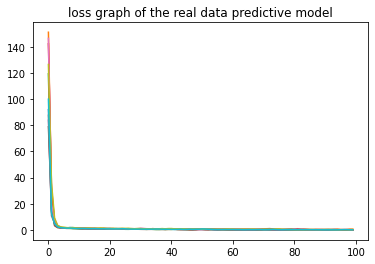

In [ ]:
for obj in hist_obj:
  i  =obj.history["loss"]
  plt.plot(i)
plt.title("loss graph of the real data predictive model")
plt.show()